# Applying Deep Learning to solve a Client Success problem - Duty Manager call prediction

GOAL: predict tickets that will generate a Duty Manager (DM) call

- ~1.5% of Db2 tickets generate DM calls; each call generates additional work/impedence for the customer, the analyst, and the Duty Manager
- if we could predict which tickets will generate DM calls, and take proactive actions on those tickets (e.g. proactively call customer), all stakeholders benefit
- train a simple deep learning model on Db2 ticket data Feb 1 - May 20, 2018
- this notebook applies that model to tickets post May 20

FEATURES:

- categorical: CASE_OWNER_ALIAS, SUPPORT_MISSION, CREATED_BY, ACCOUNT_NAME, LEGACY_PROBLEM_NUMBER, SEVERITY_LEVEL_NUMBER_FORMULA, OPERATING_SYSTEM, PRODUCT_NAME, ACCOUNT_PRIORITY, PRODUCT_VERSION, BLUE_DIAMOND_ACCOUNT
- continuous: OWNERSHIP_CHANGES
- text: SUBJECT

LABEL / TARGET:

- will the ticket generate a DM call? 0 if no; 1 if yes

CURRENT HWMs: 87% accuracy on validation; 81.5% on "wild" data

NEXT STEPS TO TRY:

- update model to incorporate DATE_OPENED feature
- work out what it would take to deploy and maintain the model in production


# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

In [1]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode

testproportion = 0.01 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = True # switch to determine whether to save model
picklemodel = True # switch for code to allow pickling of Keras model
hctextmax = 7000
maxwords = 6000

targetthresh = 6.0
emptythresh = 6000
# to address imbalance in training data between zero (above targetthresh) and detractor (below targetthresh) specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 72.8

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5


In [2]:
import urllib.request
request = urllib.request.urlopen('http://www.google.com/')
#response = urllib.urlopen(request)
#if response.getcode() == 200:
#   print("200")

In [3]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# from sklearn.preprocessing import CategoricalEncoder

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
import seaborn as sns

#model libraries


from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Ingest data <a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
if pSpace == True:    
    dm_cases = pd.read_csv('/home/paperspace/data/dmprediction/dmcasesmay202018.csv',encoding = "ISO-8859-1")
    merged_data = pd.read_csv('/home/paperspace/data/dmprediction/alldmeracasesmay20updatedjune2.csv',encoding = "ISO-8859-1")
    superset_data = pd.read_csv('/home/paperspace/data/dmprediction/alldmeracasesjune2b2018.csv',encoding = "ISO-8859-1")
    merged_data.columns = map(str.upper,merged_data.columns)
    dm_cases.columns = map(str.upper,dm_cases.columns)
    superset_data.columns = map(str.upper,superset_data.columns)



In [7]:
superset_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Industry,0,Severity 2,"Marsh & McLennan Companies, Inc.",No,10.5,NaN,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 2,SOUTH AFRICAN REVENUE SVCS,No,NaN,NaN,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,"85,508,689,864"
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 3,SAP,No,10.5,NaN,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 2,SAP,No,10.5,NaN,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Commercial,0,Severity 2,INTERNATIONAL BUSINESS MACHINES,No,9.7,NaN,HADR tuning,Support ETL,"94,575,082,000"


In [8]:
dm_cases.shape

(104, 14)

In [9]:
merged_data.shape

(7514, 15)

In [10]:
# columns = ['Col1', 'Col2', ...]
# df.drop(columns, inplace=True, axis=1)
dm_cases["target"] = 1

dm_cases.head()

,CASE_NUMBER,SUBJECT,OWNER_LAST_NAME,ACCOUNT_NAME_TEXT,CONTACT_NAME,ACCOUNT_PRIORITY,LEGACY_PROBLEM_NUMBER,SEVERITY_LEVEL,CASE_OWNER_ALIAS,BLUE_DIAMOND_ACCOUNT,COUNTRY,WATSON_SKILL_SUGGESTION_(DEPRECATED),STATUS,DATE_OPENED,target
0,TS000003163,FMP exiting with error and HeadExtentID 260611...,Ma,BELASTINGDIENST CAO,"Vannisselroy, Koen",Analytics-GEP,"28,585,211,788",3 - Minor business impact,majason,No,NL,NaN,Closed by IBM,08/11/2017,1
1,TS000003166,W R db2 load process hang for loading 5.8T rec...,BADIGER,CA Franchise Tax Board,"Jiang, Lily",NaN,"65,923,227,000",2 - Significant impact (any system is down),sbad,No,US,NaN,Closed - Archived,09/06/2017,1
2,TS000007186,UPDATE SYSSTAT.INDEXES hangs,Koranteng-Asante,"Lloyds Banking Group Service Delivery, Group IT","Nelson, Philip",NaN,Not Applicable,2 - Significant impact (any system is down),asan,No,GB,NaN,Closed - Archived,9/21/2017,1
3,TS000007630,Notified Load operation fails after revoking P...,Koranteng-Asante,STATE OF CONNECTICUT,"McCabe, Barbara",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),asan,No,US,NaN,Waiting for IBM,9/26/2017,1
4,TS000027965,Sporadic SQL SP slow performance due to invali...,Ma,21ST CENTURY INSURANCE AND FINANCIAL SERVICES,"Pentyala, Dileep Kumar",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),majason,No,US,NaN,Waiting for IBM,11/01/2017,1


In [11]:
dmcollist = list(dm_cases)
dmexlist = ['CASE_NUMBER','target']
# collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty))
dmcollist = list(set(dmcollist) - set(dmexlist))
dmcollist

['ACCOUNT_PRIORITY',
 'BLUE_DIAMOND_ACCOUNT',
 'COUNTRY',
 'SEVERITY_LEVEL',
 'LEGACY_PROBLEM_NUMBER',
 'ACCOUNT_NAME_TEXT',
 'CONTACT_NAME',
 'WATSON_SKILL_SUGGESTION_(DEPRECATED)',
 'DATE_OPENED',
 'OWNER_LAST_NAME',
 'STATUS',
 'CASE_OWNER_ALIAS',
 'SUBJECT']

In [12]:
# df.drop(columns, inplace=True, axis=1)
dm_cases.drop(dmcollist, inplace=True, axis=1)
print("dm_cases cols post pruning",list(dm_cases))

dm_cases cols post pruning ['CASE_NUMBER', 'target']


In [13]:
dm_cases.target.value_counts()

1    104
Name: target, dtype: int64

In [14]:
dm_cases.shape

(104, 2)

In [15]:
# merge the dm_cases dataframe with the overall cases dataframe
# caller.join(other.set_index('key'), on='key')
# merged_data = pd.merge(merged_data,dm_cases,on= 'CASE_NUMBER', how='outer')
# merged_data = pd.merge(merged_data,dm_cases,on= 'CASE_NUMBER', how='inner')
merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')

In [16]:
merged_data.shape

(7514, 16)

In [17]:
merged_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Industry,0,Severity 2,"Marsh & McLennan Companies, Inc.",No,10.5,NaN,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable,NaN
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 2,SOUTH AFRICAN REVENUE SVCS,No,NaN,NaN,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,"85,508,689,864",NaN
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 3,SAP,No,10.5,NaN,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable,NaN
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 2,SAP,No,10.5,NaN,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable,NaN
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Commercial,0,Severity 2,INTERNATIONAL BUSINESS MACHINES,No,9.7,NaN,HADR tuning,Support ETL,"94,575,082,000",NaN


In [18]:
merged_data.target.value_counts()

1.0    84
Name: target, dtype: int64

In [19]:
# df.loc[df['column_name'] == some_value]
messed = merged_data.loc[merged_data['SUPPORT_MISSION'].isna()]
messed.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target


In [20]:
# df['column']=df['column'].fillna(value)
merged_data['target']=merged_data['target'].fillna(0.0)
merged_data.target.value_counts()

0.0    7430
1.0      84
Name: target, dtype: int64

In [21]:
merged_data.shape

(7514, 16)

In [22]:
merged_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Industry,0,Severity 2,"Marsh & McLennan Companies, Inc.",No,10.5,NaN,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable,0.0
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 2,SOUTH AFRICAN REVENUE SVCS,No,NaN,NaN,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,"85,508,689,864",0.0
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 3,SAP,No,10.5,NaN,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable,0.0
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1,Severity 2,SAP,No,10.5,NaN,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable,0.0
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Commercial,0,Severity 2,INTERNATIONAL BUSINESS MACHINES,No,9.7,NaN,HADR tuning,Support ETL,"94,575,082,000",0.0


In [23]:
print("md shape",merged_data.shape)

md shape (7514, 16)


In [24]:
print("superset shape",superset_data.shape)

superset shape (8561, 15)


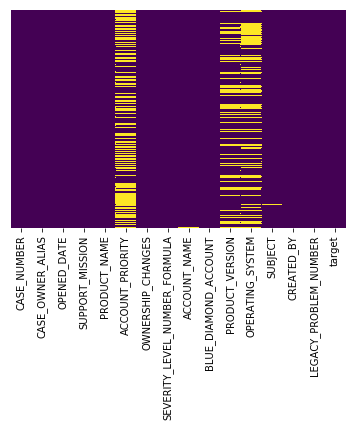

In [25]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [26]:
nearempty = []
for c in merged_data.columns:
    if np.sum(merged_data[c].isnull()) >= emptythresh :
        print(c)
        nearempty.append(c)
print(nearempty)

[]


# Clean up data

Go through steps to prepare data.

# Define test / training sets; fill in missing values; encode categorical values; process text field

In [27]:
# clean up LEGACY_PROBLEM_NUMBER
merged_data['LEGACY_PROBLEM_NUMBER'] = np.where(merged_data['LEGACY_PROBLEM_NUMBER'] == 'Not Applicable','Not Applicable','PMR')
superset_data['LEGACY_PROBLEM_NUMBER'] = np.where(superset_data['LEGACY_PROBLEM_NUMBER'] == 'Not Applicable','Not Applicable','PMR')

In [28]:
# get training and test data set
# test_size was 0.3 up to Jan 22

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)



Through train test split. Test proportion:
0.01


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [29]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['CASE_NUMBER', 'CASE_OWNER_ALIAS', 'OPENED_DATE', 'SUPPORT_MISSION', 'PRODUCT_NAME', 'ACCOUNT_PRIORITY', 'OWNERSHIP_CHANGES', 'SEVERITY_LEVEL_NUMBER_FORMULA', 'ACCOUNT_NAME', 'BLUE_DIAMOND_ACCOUNT', 'PRODUCT_VERSION', 'OPERATING_SYSTEM', 'SUBJECT', 'CREATED_BY', 'LEGACY_PROBLEM_NUMBER', 'target']


In [30]:
# define the required column lists

textcols = ['SUBJECT'] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
continuouscols = ['OWNERSHIP_CHANGES'] # columns to deal with as continuous values - no embeddings
excludefromcolist = ['CASE_NUMBER','target','OPENED_DATE'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("nearempty",len(nearempty))
print(nearempty)
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 16
nearempty 0
[]
excludefromcolist 3
['CASE_NUMBER', 'target', 'OPENED_DATE']
textcols 1
['SUBJECT']
continuouscols 1
['OWNERSHIP_CHANGES']
collist 11
['OPERATING_SYSTEM', 'ACCOUNT_PRIORITY', 'BLUE_DIAMOND_ACCOUNT', 'SEVERITY_LEVEL_NUMBER_FORMULA', 'PRODUCT_VERSION', 'PRODUCT_NAME', 'SUPPORT_MISSION', 'CREATED_BY', 'ACCOUNT_NAME', 'LEGACY_PROBLEM_NUMBER', 'CASE_OWNER_ALIAS']


In [31]:
# ensure continuous columns have numeric type
for col in continuouscols:
    print("col is",col)
    merged_data[col] = merged_data[col].astype(float)
    print("got through one")
    superset_data[col] = superset_data[col].astype(float)

col is OWNERSHIP_CHANGES
got through one


In [32]:
superset_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Industry,0.0,Severity 2,"Marsh & McLennan Companies, Inc.",No,10.5,NaN,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1.0,Severity 2,SOUTH AFRICAN REVENUE SVCS,No,NaN,NaN,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,PMR
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1.0,Severity 3,SAP,No,10.5,NaN,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1.0,Severity 2,SAP,No,10.5,NaN,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Commercial,0.0,Severity 2,INTERNATIONAL BUSINESS MACHINES,No,9.7,NaN,HADR tuning,Support ETL,PMR


In [33]:
merged_data.head()


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Industry,0.0,Severity 2,"Marsh & McLennan Companies, Inc.",No,10.5,NaN,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable,0.0
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1.0,Severity 2,SOUTH AFRICAN REVENUE SVCS,No,NaN,NaN,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,PMR,0.0
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1.0,Severity 3,SAP,No,10.5,NaN,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable,0.0
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",NaN,1.0,Severity 2,SAP,No,10.5,NaN,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable,0.0
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Commercial,0.0,Severity 2,INTERNATIONAL BUSINESS MACHINES,No,9.7,NaN,HADR tuning,Support ETL,PMR,0.0


In [34]:
superset_data.dtypes

CASE_NUMBER                       object
CASE_OWNER_ALIAS                  object
OPENED_DATE                       object
SUPPORT_MISSION                   object
PRODUCT_NAME                      object
ACCOUNT_PRIORITY                  object
OWNERSHIP_CHANGES                float64
SEVERITY_LEVEL_NUMBER_FORMULA     object
ACCOUNT_NAME                      object
BLUE_DIAMOND_ACCOUNT              object
PRODUCT_VERSION                   object
OPERATING_SYSTEM                  object
SUBJECT                           object
CREATED_BY                        object
LEGACY_PROBLEM_NUMBER             object
dtype: object

In [35]:
merged_data.dtypes

CASE_NUMBER                       object
CASE_OWNER_ALIAS                  object
OPENED_DATE                       object
SUPPORT_MISSION                   object
PRODUCT_NAME                      object
ACCOUNT_PRIORITY                  object
OWNERSHIP_CHANGES                float64
SEVERITY_LEVEL_NUMBER_FORMULA     object
ACCOUNT_NAME                      object
BLUE_DIAMOND_ACCOUNT              object
PRODUCT_VERSION                   object
OPERATING_SYSTEM                  object
SUBJECT                           object
CREATED_BY                        object
LEGACY_PROBLEM_NUMBER             object
target                           float64
dtype: object

In [36]:
superset_data['LEGACY_PROBLEM_NUMBER'].head(10)

0    Not Applicable
1               PMR
2    Not Applicable
3    Not Applicable
4               PMR
5    Not Applicable
6    Not Applicable
7    Not Applicable
8               PMR
9               PMR
Name: LEGACY_PROBLEM_NUMBER, dtype: object

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [37]:
# fill missing values
print("before mv")
def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)


train = fill_missing(train)
test = fill_missing(test)
# also remove missing data from superset dataset used for encodings
superset_data = fill_missing(superset_data)
train.head(3)


before mv


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
6666,TS000883298,jshuang,05/08/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",missing,0,Severity 3,"JTEKT (CHINA) CO.,LTD",No,10.5,AIX,GCGTSC@EH:Db2 software download inquiry,Support ETL,PMR,0.0
5863,TS000829287,xufufei,4/25/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Analytics-Enterprise,2,Severity 3,CHINA MERCHANTS BANK,No,10.5,AIX,Attn Pals(Need Help):GCGTSC@EH:CMB v105fp5 SYS...,Support ETL,PMR,0.0
2183,TS000126251,KUMI,2/28/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",missing,0,Severity 3,5Y0UZ JCB,No,9.7,AIX,Db2????????????????,Syuhichi Shirota,Not Applicable,0.0


In [38]:
verboseout == True

True

In [39]:
# process categorical data
# replace values with category IDs in the following columns
# 



lelist = {}

# le = CategoricalEncoder(encoding='ordinal', handle_unknown='ignore')

for col in collist:
    le = LabelEncoder()
    if verboseout:
        print("processing ",col)
    # fit on superset to ensure encoding includes future data but only model on past data
    # np.hstack([superset_data[col]])
    le.fit(np.hstack([superset_data[col]]))
    superset_data[col] = le.transform(superset_data[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    lelist[col] = le
    del le
    
    
# del le


train.head(5)
    

processing  OPERATING_SYSTEM
processing  ACCOUNT_PRIORITY


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


processing  BLUE_DIAMOND_ACCOUNT
processing  SEVERITY_LEVEL_NUMBER_FORMULA
processing  PRODUCT_VERSION
processing  PRODUCT_NAME
processing  SUPPORT_MISSION
processing  CREATED_BY
processing  ACCOUNT_NAME
processing  LEGACY_PROBLEM_NUMBER
processing  CASE_OWNER_ALIAS


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
6666,TS000883298,169,05/08/2018,0,6,18,0,2,1198,1,5,0,GCGTSC@EH:Db2 software download inquiry,1819,1,0.0
5863,TS000829287,261,4/25/2018,0,6,4,2,2,426,1,5,0,Attn Pals(Need Help):GCGTSC@EH:CMB v105fp5 SYS...,1819,1,0.0
2183,TS000126251,63,2/28/2018,0,6,18,0,2,24,1,30,0,Db2????????????????,1841,0,0.0
6590,TS000880423,95,05/07/2018,0,6,2,0,2,952,1,2,2,DB2 production environment - application conne...,273,0,0.0
5213,TS000212236,66,4/16/2018,0,6,7,0,2,889,1,2,2,180426 - 0 Card value in syscat.tables,239,0,0.0


In [40]:
superset_data.head(5)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER
0,TS000104648,13,02/01/2018,0,6,10,0.0,1,1373,1,5,5,DB2 running out of disk space during data-inte...,109,0
1,TS000104657,119,02/01/2018,0,6,18,1.0,1,1798,1,40,5,C-3/27-(0)-W4F 180205 insert and delete transa...,1819,1
2,TS000104966,244,02/01/2018,0,6,18,1.0,2,1717,1,5,5,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,276,0
3,TS000105031,59,02/01/2018,0,6,18,1.0,1,1717,1,5,5,SAP 47709/2018 - Productive Database db2 down ...,1096,0
4,TS000105069,112,02/01/2018,0,6,2,0.0,1,1123,1,30,5,HADR tuning,1819,1


In [41]:
train['SUBJECT'].head(10)

6666              GCGTSC@EH:Db2 software download inquiry
5863    Attn Pals(Need Help):GCGTSC@EH:CMB v105fp5 SYS...
2183                                  Db2????????????????
6590    DB2 production environment - application conne...
5213               180426 - 0 Card value in syscat.tables
1683                                           "Dear team
811     02/14 - WC: To know about the option "mon report"
2453                      Search was failed with  SQL0901
5145    PdO - System is creating FODC file on home fil...
6293                         DB2 services Unexpected Down
Name: SUBJECT, dtype: object

In [42]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=maxwords,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    


processing text col SUBJECT


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
train['SUBJECT'].head(10)

6666                            [3, 38, 1, 392, 214, 187]
5863    [48, 86, 47, 93, 3, 38, 1041, 543, 1154, 393, ...
2183                                                  [1]
6590    [1, 82, 199, 63, 92, 311, 687, 287, 2002, 138,...
5213                   [1586, 58, 1156, 490, 5, 609, 206]
1683                                          [2901, 394]
811       [269, 610, 135, 2, 585, 139, 11, 443, 688, 644]
2453                              [466, 66, 36, 12, 2902]
5145         [2903, 59, 14, 507, 165, 56, 4, 832, 56, 59]
6293                                    [1, 444, 215, 71]
Name: SUBJECT, dtype: object

In [44]:
# max values for embeddings



max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



maxtrain.max() 5999
maxtest .max() 5651
textmax 7000
max_dict {'OPERATING_SYSTEM': 6, 'ACCOUNT_PRIORITY': 19, 'BLUE_DIAMOND_ACCOUNT': 2, 'SEVERITY_LEVEL_NUMBER_FORMULA': 4, 'PRODUCT_VERSION': 43, 'PRODUCT_NAME': 28, 'SUPPORT_MISSION': 1, 'CREATED_BY': 2276, 'ACCOUNT_NAME': 2215, 'LEGACY_PROBLEM_NUMBER': 2, 'CASE_OWNER_ALIAS': 269, 'SUBJECT': 5999}


# Split training set into train / validate

In [45]:
# define and scale target and get validation sets
# apar_ds['TTRgtthresh'] = np.where(apar_ds['Time_to_relief'] >= ttrthresh,1,0)

# train["target"] = np.where(traintrain["LIKELIHOOD_TO_RECOMMEND"]

# train["target"] = train["Time_to_relief"]

#train["target"] = np.log(train.Time_to_relief+1)
#target_scaler = MinMaxScaler(feature_range=(-1, 1))
#train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
#pd.DataFrame(train.target).hist()

# train_size 0.8 up to Jan 22
dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

# modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
#          , validation_data=(X_valid, dvalid.target), verbose=1)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head(10)
else:
    #trn_labels[:4]
    print(dtrain["target"][:2])
    print(dvalid.target[:2])
    




(5950, 16)
(1488, 16)


In [46]:
# print counts of target values for data sets
print("zero target values: all",(merged_data["target"]==0).sum())
print("one target values: all",(merged_data["target"]==1).sum())
print("zero target values: dtrain",(dtrain["target"]==0).sum())
print("one target values: dtrain",(dtrain["target"]==1).sum())
print("zero target values: dvalid",(dvalid["target"]==0).sum())
print("one target values: dvalid",(dvalid["target"]==1).sum())


zero target values: all 7430
one target values: all 84
zero target values: dtrain 5883
one target values: dtrain 67
zero target values: dvalid 1471
one target values: dvalid 17


In [47]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input
X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)
print("keras variables defined")
print("X_train_list",X_train_list)





cat col is OPERATING_SYSTEM
cat col is ACCOUNT_PRIORITY
cat col is BLUE_DIAMOND_ACCOUNT
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
cat col is PRODUCT_VERSION
cat col is PRODUCT_NAME
cat col is SUPPORT_MISSION
cat col is CREATED_BY
cat col is ACCOUNT_NAME
cat col is LEGACY_PROBLEM_NUMBER
cat col is CASE_OWNER_ALIAS
text col is SUBJECT
cont col is OWNERSHIP_CHANGES
cat col is OPERATING_SYSTEM
cat col is ACCOUNT_PRIORITY
cat col is BLUE_DIAMOND_ACCOUNT
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
cat col is PRODUCT_VERSION
cat col is PRODUCT_NAME
cat col is SUPPORT_MISSION
cat col is CREATED_BY
cat col is ACCOUNT_NAME
cat col is LEGACY_PROBLEM_NUMBER
cat col is CASE_OWNER_ALIAS
text col is SUBJECT
cont col is OWNERSHIP_CHANGES
cat col is OPERATING_SYSTEM
cat col is ACCOUNT_PRIORITY
cat col is BLUE_DIAMOND_ACCOUNT
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
cat col is PRODUCT_VERSION
cat col is PRODUCT_NAME
cat col is SUPPORT_MISSION
cat col is CREATED_BY
cat col is ACCOUNT_NAME
cat col is LEGACY_P

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [48]:
# define model in keras

# basic imports


def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# original lambda l2_lambda = 0.0001
# for 5 x increase in dataset, increase lambda 5x


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


def get_model():
    
   
    #Inputs
    # name = Input(shape=[X_train["name"].shape[1]], name="name")
    #Prob_Abstract_Text = Input(shape=[X_train["Prob_Abstract_Text"].shape[1]], name="Prob_Abstract_Text")
    # Country = Input(shape=[1], name="Country")
    # Release = Input(shape=[1], name="Release")
    #Release_Linear = Input(shape=[1], name="Release_Linear")
    #Report_Date_days = Input(shape=[1], name="Report_Date_days")
    
    catinputs = {}
    textinputs = {}
    continputs = {}
    embeddings = {}
    textembeddings = {}
    catemb = 10
    textemb = 50
    
    print("about to define embeddings")
    
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        #print("type inputname",type(inputname))
        #print("catinputs[col] type", type(catinputs[col]))
        #catinputs[col] = Input(shape=[1],name=col)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    
    
    # text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        #textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
        # continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
    #rnn layer here if there were text fields
        
    # rnn_layer1 = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (emb_Abstract))
    # rnn_layer2 = GRU(8) (emb_name)
    
    #concatlist = []
    #for cols in collist:
    #    concatlist = concatlist+(Dropout(dropout_rate) (Flatten() (embeddings[cols])))
    #print("concatlist",concatlist)
    # 'ACCOUNT_NAME', 'CASE_OWNER_ALIAS'
          
    # main_l = concatenate([
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['ACCOUNT_NAME']) ),Dropout(dropout_rate) (Flatten() (embeddings['CASE_OWNER_ALIAS']) )])
    for cols in collist:
        if (cols != 'ACCOUNT_NAME') & (cols != 'CASE_OWNER_ALIAS'):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
    # originally 2 dense layers here, sizes were 128 / 64 
    #main_l2 = Dropout(dr_r) (Dense(128,kernel_regularizer=l2(l2_lambda)) (main_l))
    # main_l3 = Dropout(dropout_rate) (Dense(32,kernel_regularizer=l2(l2_lambda)) (main_l))
    
    #output
    # change to softmax for TTRthreshold
    #output = Dense(1, activation="linear") (main_l)
    #output = Dense(1, activation="softmax") (main_l)
    
    
    #output = Dense(1, activation="sigmoid") (main_l)
    output = Dense(1, activation="sigmoid") (main_l)
    # output = Dense(1, activation="linear") (main_l)
    
    #model
        
    # model = Model([Country,Release,Comp_name,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, System_Down_Indicator, Prob_Abstract_Text], output)
    # model = Model([Country,Release,Product,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    #model = Model([Country,Release_Linear,Product,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    # [Country, Report_Date_days,Comp_name,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text, Release_Linear]
                                                   
    model = Model(inputlayerlist, output)
    
    # model = Model([Country,Release,Product,Initial_Severity_Linear,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    # optimizer = SGD(lr=0.01, momentum=0.4)
    
    
    # optimizer = Adam(lr=learning_rate)
    optimizer = SGD(lr=learning_rate)
   
    # optimizer = SGD(lr=0.5)
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
      
    
    return model

    
model = get_model()
#if dsxmode == False:
   ## plot_model(model, to_file='/home/paperspace/visualizations/dmmodelplotmay23b.png', show_shapes=True, show_layer_names=True)
model.summary()
    

    

about to define embeddings
about to define embeddings
textmax is 7000
col SUBJECT
text input shape 5999
max in the midst 5999
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_12/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ACCOUNT_NAME (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
CASE_OWNER_ALIAS (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 10)        22150       ACCOUNT_NAME[0][0]               
_________________________________________

In [49]:
BATCH_SIZE = 200
epochs = 10
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)


model = get_model()
modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols ['SUBJECT']
dropout  0.0003
L2 lambda  0.0003
batch size  200
about to define embeddings
about to define embeddings
textmax is 7000
col SUBJECT
text input shape 5999
max in the midst 5999
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_24/concat:0", shape=(?, ?), dtype=float32)
Train on 5950 samples, validate on 1488 samples
Epoch 1/10
5950/5950 [==============================] - 165s 28ms/step - loss: 1.3696 - acc: 0.5126 - weighted_acc: 0.9591 - val_loss: 0.6674 - val_acc: 0.7903 - val_weighted_acc: 0.7903
Epoch 2/10
5950/5950 [==============================] - 162s 27ms/step - loss: 1.2522 - acc: 0.5696 - weighted_acc: 1.0281 - val_loss: 0.6654 - val_acc: 0.8071 - val_weighted_acc: 0.8071
Epoch 3/10
5950/5950 [==============================] - 164s 27ms/step - loss: 1.1803 - acc: 0.6059 - weighted_acc: 1.1006 - val_loss: 0.6622 - val_acc: 0.8259 - val_weighted_acc: 0.8259
Epoch 4/10
5950/5950 [==============================]

In [51]:
if savemodel == True:
    model_json = model.to_json()
    with open('/home/paperspace/models/modelaug4.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('/home/paperspace/models/dmweightsaug4.h5')
    
    # save tokenizer tok_raw for text and label encoder for categorical cols
    with open('/home/paperspace/models/tokenizeraug4.pickle', 'wb') as handle:
        pickle.dump(tok_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('/home/paperspace/models/leaug4.pickle', 'wb') as handle2:
        pickle.dump(lelist, handle2, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved model, weights, tokenizer and label encoder to disk")
    with open('/home/paperspace/models/neaug4.pickle', 'wb') as handle3:
        pickle.dump(nearempty, handle3, protocol=pickle.HIGHEST_PROTOCOL)
    model.save('/home/paperspace/models/dmmodelaug4.h5')
    # nearempty

Saved model, weights, tokenizer and label encoder to disk


# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [ ]:
from keras.models import model_from_json
json_file = open('/home/paperspace/models/modeljune3c.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('/home/paperspace/models/DMweightsjune3c.h5')
optimizer = SGD(lr=learning_rate)
loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])

In [ ]:
if presaved == True:
    from keras.models import model_from_json
    json_file = open('/home/paperspace/models/modeljune3c.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('/home/paperspace/models/DMweightsjune3c.h5')
    optimizer = SGD(lr=learning_rate)
    loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    

In [ ]:
if presaved == True:
    BATCH_SIZE = 200
    epochs = 1
    modelfit2 = new_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

In [ ]:
# loaded_model.save('/home/paperspace/models/pickledmodeljune7.p')

In [ ]:
new_model.summary()

# Block to pickle model so it can be ingested in Watson Studio
1. load saved model
2. run make_keras_picklable()
3. pickle model

In [4]:
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

In [5]:
from keras.models import load_model
new_model = load_model('/home/paperspace/models/DMmodelaug2.h5')

In [6]:
make_keras_picklable()

In [7]:
with open('/home/paperspace/models/pickledmodelaug2.pickle', 'wb') as handle:
        pickle.dump(new_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/home/paperspace/models/pickledmodeljune7.pickle', 'rb') as pickle_file:
    newest_model = pickle.load(pickle_file)


In [ ]:
type(newest_model)

In [ ]:
new_model.summary()

# Advanced visualizations

In [ ]:
new_model.layers

In [ ]:
type(new_model.layers)

In [ ]:
new_model.layers[2]

In [ ]:
new_model.layers[2].name

In [ ]:
type(new_model.layers[2])

In [ ]:
new_model.layers[2].input[0]

In [ ]:
# get weights from an embedding layer
new_model.layers[2].get_weights()

In [ ]:
new_model.layers[2].get_weights()[0].shape

In [ ]:
new_model.layers[2].get_weights()[0]

In [ ]:
new_model.layers[2].get_weights()[0][0]

In [ ]:
type(new_model.layers[2].get_weights()[0])

In [ ]:
type(new_model.layers[2].get_weights()[0][0])

In [ ]:
import os

os.getcwd()

In [ ]:
def get_embedding(model,embeddingname,embeddinglayer):
# pd.DataFrame(data=data[1:,1:],    # values
# ...              index=data[1:,0],    # 1st column as index
# ...              columns=data[0,1:]) 
    # new_model.layers[2].get_weights()
    # data=data[1:,1:]
    df = pd.DataFrame(data=model.layers[embeddinglayer].get_weights()[0][0:,0:])
    return(df)
    
    

In [ ]:
embedding_df.head()

In [ ]:
# attempt to adapt cryptic example at https://stackoverflow.com/questions/41665390/is-it-possible-to-visualize-keras-embeddings-in-tensorboard/41707319#41707319

# to launch: command line:  tensorboard --logdir=path/to/log-directory
# tensorboard --logdir=/tmp/tfboard
# tensorboard --logdir tfboard
# Once TensorBoard is running, navigate your web browser to localhost:6006 to view the TensorBoard


import os

import keras
import tensorflow

ROOT_DIR = '/tmp/tfboard'

os.makedirs(ROOT_DIR, exist_ok=True)
embeddingname = 'embedding_31'
embeddinglayer = 2


OUTPUT_MODEL_FILE_NAME = os.path.join(ROOT_DIR,'tf.ckpt')

# get the keras model
# model = get_model()
# get the tensor name from the embedding layer
# embeddings.Embedding
# tensor_name = next(filter(lambda x: x.name == 'embedding', newest_model.layers)).W.name

# tensor_name = 

# ACCOUNT_NAME is embedding_31, aka new_model.layers[2]
tensor_name = next(filter(lambda x: x.name == embeddingname, new_model.layers)).output.name
print("tensor_name",tensor_name)

# the vocabulary
# metadata_file_name = os.path.join(ROOT_DIR,tensor_name)
metadata_file_name = os.path.join(ROOT_DIR,embeddingname)
print("metadata_file_name",metadata_file_name)

embedding_df = get_embedding(new_model,embeddingname,embeddinglayer) # don't have a native definition for this
print("defined embedding_df")
print("df shape",embedding_df.shape)
embedding_df.head(5)
print("after defined embedding_df")

embedding_df.to_csv(metadata_file_name, header=False, columns=[]) # columns=[] means no columns written


saver = tensorflow.train.Saver() # The Saver class adds ops to save and restore variables to and from checkpoints. It also provides convenience methods to run these ops.
saver.save(keras.backend.get_session(), OUTPUT_MODEL_FILE_NAME) # This method runs the ops added by the constructor for saving variables. It requires a session in which the graph was launched. The variables to save must also have been initialized.
# session is keras.backend.get_session() - Returns the TF session to be used by the backend.


# summary_writer = tensorflow.train.SummaryWriter(ROOT_DIR) # tf.train.SummaryWriter is deprecated, instead use tf.summary.FileWriter
summary_writer = tensorflow.summary.FileWriter(ROOT_DIR)

config = tensorflow.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tensor_name
embedding.metadata_path = metadata_file_name
tensorflow.contrib.tensorboard.plugins.projector.visualize_embeddings(summary_writer, config)


In [ ]:
tensor_name

In [ ]:
plot_model(newest_model, to_file='/home/paperspace/visualizations/dmmodelplotjune9b.png', show_shapes=True, show_layer_names=True)

# Predictions and renderings

In [ ]:
# functions to parse and manipulate dates in the style of the input CSVs
import datetime
from datetime import date
def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [ ]:
# predictions on training set

preds = model.predict(X_train, batch_size=BATCH_SIZE)

In [ ]:
len(lelist)

In [ ]:
preds.shape

In [ ]:
preds[:50]

In [ ]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

In [ ]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [ ]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

In [ ]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

In [ ]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



In [ ]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





In [ ]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [ ]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


In [ ]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

In [ ]:
dvalidright.head(20)

In [ ]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [ ]:
# ,encoding = "ISO-8859-1"
if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')

In [ ]:
dtrain.target[:50]

In [ ]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


In [ ]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

In [ ]:
from sklearn import metrics

cfmap=metrics.confusion_matrix(y_true=dvalid['target'],  # True labels
                         y_pred=dvalid["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for DM prediction (weighted)")
plt.show()

In [ ]:
model.metrics_names

In [ ]:
list(le.classes_)

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.